<a href="https://colab.research.google.com/github/simbelus13/2D-flow-around-cylinder/blob/main/Vortex_Shedding_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vortex Shedding Simulation
This notebook simulates the phenomenon of vortex shedding in a 2D incompressible flow around a cylinder.
The goal is to study the flow behavior at different Reynolds numbers and visualize the velocity field,
streamlines, and vorticity.

## Governing Equations
We solve the Navier-Stokes equations for incompressible flow:
1. Continuity equation: ∇·u = 0
2. Momentum equation: ∂u/∂t + (u·∇)u = -∇p + (1/Re)∇²u

Iteration 0/10000 completed.
Iteration 1000/10000 completed.
Iteration 2000/10000 completed.
Iteration 3000/10000 completed.
Iteration 4000/10000 completed.
Iteration 5000/10000 completed.
Iteration 6000/10000 completed.
Iteration 7000/10000 completed.
Iteration 8000/10000 completed.
Iteration 9000/10000 completed.


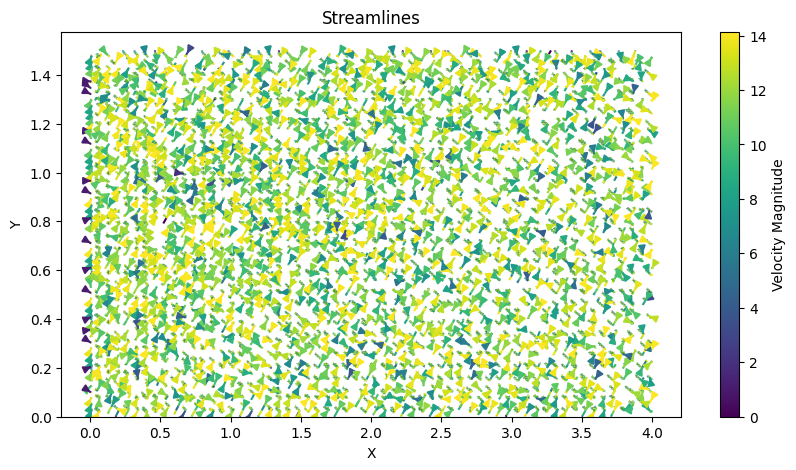

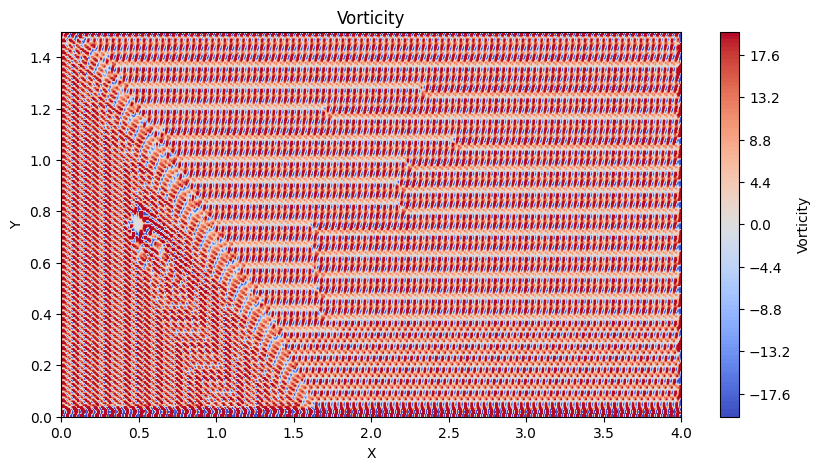

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters
Re = 10  # Reduced Reynolds number for smoother flow
nx, ny = 600, 200  # Higher resolution
Lx, Ly = 4.0, 1.5  # Larger domain
dx, dy = Lx / nx, Ly / ny  # Grid spacing
dt = 0.00005  # Smaller time step for stability
iterations = 10000  # Increased iterations for full flow development

# Cylinder parameters
cylinder_center = (0.5, 0.75)  # Adjusted center to fit larger domain
cylinder_radius = 0.05  # Radius of cylinder

# Generate grid
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing='xy')

# Initialize velocity and pressure fields
u = np.zeros((ny, nx))  # x-velocity
v = np.zeros((ny, nx))  # y-velocity
p = np.zeros((ny, nx))  # Pressure

# Add small, smoothed perturbations to velocity
u += gaussian_filter(0.01 * np.random.rand(*u.shape), sigma=2)
v += gaussian_filter(0.01 * np.random.rand(*v.shape), sigma=2)

# Mask for the cylinder
cylinder_mask = (X - cylinder_center[0])**2 + (Y - cylinder_center[1])**2 < cylinder_radius**2

# Apply initial conditions
u[:, 0] = 1.0  # Inlet velocity
u[cylinder_mask] = 0  # No velocity inside cylinder
v[cylinder_mask] = 0  # No velocity inside cylinder

def apply_boundary_conditions(u, v):
    # Inlet
    u[:, 0] = 1.0
    v[:, 0] = 0.0

    # Outlet (Neumann condition, zero gradient)
    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]

    # No-slip walls (top and bottom)
    u[0, :] = 0.0
    u[-1, :] = 0.0
    v[0, :] = 0.0
    v[-1, :] = 0.0

    return u, v

def solve_navier_stokes(u, v, p, iterations):
    for step in range(iterations):
        # Compute gradients scaled by grid spacing
        du_dx, du_dy = np.gradient(u, dx, dy, edge_order=2)
        dv_dx, dv_dy = np.gradient(v, dx, dy, edge_order=2)
        dp_dx, dp_dy = np.gradient(p, dx, dy, edge_order=2)

        # Update velocities with central differences
        u_new = u + dt * (
            -u * du_dx - v * du_dy
            + dp_dx
            + (1 / Re) * (np.gradient(du_dx, dx, axis=1) + np.gradient(du_dy, dy, axis=0))
        )
        v_new = v + dt * (
            -u * dv_dx - v * dv_dy
            + dp_dy
            + (1 / Re) * (np.gradient(dv_dx, dx, axis=1) + np.gradient(dv_dy, dy, axis=0))
        )

        # Divergence-free condition for pressure update
        div_u = du_dx + dv_dy
        p_new = p - dt * div_u

        # Enforce incompressibility
        u_new -= div_u * dx
        v_new -= div_u * dy

        # Apply cylinder boundary conditions
        u_new[cylinder_mask] = 0
        v_new[cylinder_mask] = 0

        # Apply boundary conditions
        u_new, v_new = apply_boundary_conditions(u_new, v_new)

        # Clamp values to avoid overflow
        u_new = np.clip(u_new, -10.0, 10.0)
        v_new = np.clip(v_new, -10.0, 10.0)
        p_new = np.clip(p_new, -10.0, 10.0)

        # Update fields
        u, v, p = u_new, v_new, p_new

        # Print progress every 1000 iterations
        if step % 1000 == 0:
            print(f"Iteration {step}/{iterations} completed.")

    return u, v, p

# Solve the equations
u, v, p = solve_navier_stokes(u, v, p, iterations)

# Streamlines
plt.figure(figsize=(10, 5))
plt.streamplot(X, Y, u, v, color=np.sqrt(u**2 + v**2), cmap='viridis', density=2)
plt.title("Streamlines")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Velocity Magnitude")
plt.show()

# Vorticity
vorticity = np.gradient(v, dx, axis=0) - np.gradient(u, dy, axis=1)
vorticity = gaussian_filter(vorticity, sigma=1)

plt.figure(figsize=(10, 5))
plt.contourf(X, Y, np.clip(vorticity, -20, 20), levels=100, cmap='coolwarm')
plt.title("Vorticity")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Vorticity")
plt.show()
